In [4]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [6]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596019 entries, 0 to 1596018
Data columns (total 2 columns):
text      1596019 non-null object
target    1596019 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [7]:
x = my_df.text
y = my_df.target

In [9]:
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [10]:
print "Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100)
print "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100)
print "Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100)

Train set has total 1564098 entries with 50.00% negative, 50.00% positive
Validation set has total 15960 entries with 50.40% negative, 49.60% positive
Test set has total 15961 entries with 50.26% negative, 49.74% positive


In [11]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [27]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [28]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [32]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596019/1596019 [00:01<00:00, 974931.80it/s]


In [33]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 1596019/1596019 [00:01<00:00, 1118170.79it/s]


CPU times: user 22min 1s, sys: 1min 3s, total: 23min 5s
Wall time: 9min 37s


In [38]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596019/1596019 [00:02<00:00, 533098.47it/s]


In [39]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 1596019/1596019 [00:01<00:00, 1137897.00it/s]


CPU times: user 41min 35s, sys: 31.7 s, total: 42min 7s
Wall time: 12min 35s


In [112]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

# Prepration for Convolutional Neural Network

In the last post, I have aggregated the word vectors of each word in a tweet, either summation or calculating mean to get one vector representation of each tweet. However, in order to feed to a CNN, we have to not only feed each word vector to the model, but also in a sequence which matches the original tweet.

For example, let's say we have a sentence as below.

"I love cats"

And let's assume that we have a 2-dimensional vector representation of each word as follows:

I: [0.3, 0.5]
love: [1.2, 0.8]
cats: [0.4, 1.3]

With the above sentence, the dimension of the vector we have for the whole sentence is 3 X 2 (3: number of words, 2: number of vector dimension).

But there is one more thing we need to consider. A neural network model will expect all the data to have the same dimension, but in case of different sentences, they will have different lengths. This can be handled with padding.

Let's say we have our second sentence as below.

"I love dogs too"

with the below vector representation of each word:

I: [0.3, 0.5], love: [1.2, 0.8], dogs: [0.8, 1.2], too: [0.1, 0.1]

The first sentence had 3X2 dimension vectors, but the second sentence has 4X2 dimension vector. Our neural network won't accept these as inputs. By padding the inputs, we decide the maximum length of words in a sentence, then zero pads the rest, if the input length is shorter than the designated length. In the case where it exceeds the maximum length, then it will also truncate either from the beginning or from the end. For example, let's say we decide our maximum length to be 5.

Then by padding, the first sentence will have 2 more 2-dimensional vectors of all zeros at the start or the end (you can decide this by passing an argument), and the second sentence will have 1 more 2-dimensional vector of zeros at the beginning or the end. Now we have 2 same dimensional (5X2) vectors for each sentence, and we can finally feed this to a model.

Let's first load the Word2Vec models to extract word vectors from. I have saved the Word2Vec models I trained in the previous post, and can easily be loaded with "KeyedVectors" function in Gensim. I have two different Word2Vec models, one with CBOW (Continuous Bag Of Words) model, and the other with a skip-gram model. I won't go into detail of how CBOW and skip-gram differs, but you can refer to my previous post if you want to know a bit more in detail.

In [11]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [12]:
len(model_ug_cbow.wv.vocab.keys())

106257

By running below code block, I am constructing a sort of dictionary I can extract the word vectors from. Since I have two different Word2Vec models, below "embedding_index" will have concatenated vectors of the two models. For each model, I have 100 dimension vector representation of the words, and by concatenating each word will have 200 dimension vector representation.

In [13]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 106257 word vectors.


Now we have our reference to word vectors ready, but we still haven't prepared data to be in the format I have explained at the start of the post. Keras' 'Tokenizer' will split each word in a sentence,  then we can call 'texts_to_sequences' method to get the sequential representation of each sentence. We also need to pass 'num_words' which is a number of vocabularies you want to use, and this will be applied when you call 'texts_to_sequences' method. This might be a bit counter-intuitive since if you check the length of all the word index, it will not be the number of words you defined, but the actual screening process happens when you call 'texts_to_sequences' method.

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [12]:
len(tokenizer.word_index)

261650

Below are the first five entries of the original train data.

In [62]:
for x in x_train[:5]:
    print x

hate you
got physics exam jealous
holy shit new vending machine blue lcd bit but no fun carousel delivery system
ha no went to real gym swear look what found of our fave things chocolate nathan
loved my doggie kisses made my day can not tell little bear tho


And the same data prepared as sequential dats is as below.

In [63]:
sequences[:5]

[[137, 6],
 [45, 2569, 410, 555],
 [1311, 353, 69, 9569, 1496, 855, 9411, 235, 17, 35, 104, 18470, 2871, 1443],
 [384,
  35,
  203,
  1,
  372,
  629,
  1491,
  202,
  46,
  302,
  11,
  177,
  1417,
  223,
  673,
  4994],
 [502, 3, 4487, 2134, 195, 3, 29, 26, 7, 253, 157, 1758, 329]]

Each word is represented as a number, and we can see that the number of words in each sentence is matching the length of numbers in the "sequences". We can later make connections of which word each number represents. But we still didn't pad our data, so each sentence has varying length. Let's deal with this.

In [152]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [153]:
max(length)

40

The maximum number of words in a sentence within the training data is 40. Let's decide the maximum length to be a bit longer than this, let's say 45.

In [81]:
x_train_seq = pad_sequences(sequences, maxlen=45)
print('Shape of data tensor:', x_train_seq.shape)

('Shape of data tensor:', (1564098, 45))


In [65]:
x_train_seq[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   137,     6],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    45,  2569,   410,   555],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  1311,   353,    69,  9569,  1496,
    

As you can see from the padded sequences, all the data now transformed to have the same length of 45, and by default, Keras zero-pads at the beginning, if a sentence length is shorter than the maximum length. If you want to know more in detail, please check the Keras documentation on sequence preprocessing. https://keras.io/preprocessing/sequence/

In [82]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=45)

There's still one more thing left to do before we can feed the sequential text data to a model. When we transformed a sentence into a sequence, each word is represented by an integer number. Actually, these numbers are where each word is stored in the tokenizer's word index. Keeping this in mind, let's build a matrix of these word vectors, but this time we will use the word index number so that our model can refer to the corresponding vector when fed with integer sequence.

Below, I am defining the number of words to be 100,000. This means I will only care about 100,000 most frequent words in the training set. If I don't limit the number of words, the total number of vocabulary will be more than 200,000.

In [83]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

As a sanity check, if the embedding matrix has been generated properly. In the above, when I saw the first five entries of the training set, the first entry was "hate you", and the sequential representation of this was [137, 6]. Let's see if 6th embedding matrix is as same as vectors for the word 'you'.

In [84]:
np.array_equal(embedding_matrix[6] ,embeddings_index.get('you'))

True

Now we are ready with the data preparation. Before we jump into CNN, I would like to test one more thing (sorry for the delay). When we feed this sequential vector representation of data, we will use Embedding layer in Keras. With Embedding layer, I can either pass pre-defined embedding, which I prepared as 'embedding_matrix' above, or Embedding layer itself can learn word embeddings as the whole model trains. And another possibility is we can still feed the pre-defined embedding but make it trainable so that it will update the values of vectors as the model trains.

In order to check which method performs better, I defined a simple shallow neural network one hidden layer. For this model structure, I will not try to refine models by tweaking parameters, since the main purpose of this post is to implement CNN.

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [9]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [85]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 1394s - loss: 0.4614 - acc: 0.7799 - val_loss: 0.4479 - val_acc: 0.7909
Epoch 2/5
 - 1416s - loss: 0.4262 - acc: 0.8014 - val_loss: 0.4405 - val_acc: 0.7955
Epoch 3/5
 - 1342s - loss: 0.3997 - acc: 0.8167 - val_loss: 0.4512 - val_acc: 0.7932
Epoch 4/5
 - 1315s - loss: 0.3730 - acc: 0.8313 - val_loss: 0.4679 - val_acc: 0.7841
Epoch 5/5
 - 1297s - loss: 0.3475 - acc: 0.8450 - val_loss: 0.4943 - val_acc: 0.7844


In [87]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=45)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 10985s - loss: 0.4219 - acc: 0.8054 - val_loss: 0.4029 - val_acc: 0.8210
Epoch 2/5
 - 10984s - loss: 0.3718 - acc: 0.8346 - val_loss: 0.4048 - val_acc: 0.8195
Epoch 3/5
 - 10975s - loss: 0.3236 - acc: 0.8595 - val_loss: 0.4293 - val_acc: 0.8161
Epoch 4/5
 - 11475s - loss: 0.2722 - acc: 0.8847 - val_loss: 0.4762 - val_acc: 0.8019
Epoch 5/5
 - 12110s - loss: 0.2277 - acc: 0.9052 - val_loss: 0.5349 - val_acc: 0.7951


In [88]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 11945s - loss: 0.4226 - acc: 0.8051 - val_loss: 0.4068 - val_acc: 0.8163
Epoch 2/5
 - 11473s - loss: 0.3783 - acc: 0.8305 - val_loss: 0.4086 - val_acc: 0.8186
Epoch 3/5
 - 10964s - loss: 0.3421 - acc: 0.8492 - val_loss: 0.4171 - val_acc: 0.8222
Epoch 4/5
 - 10968s - loss: 0.2992 - acc: 0.8708 - val_loss: 0.4530 - val_acc: 0.8137
Epoch 5/5
 - 10956s - loss: 0.2575 - acc: 0.8907 - val_loss: 0.4974 - val_acc: 0.8071


As a result, the best validation accuracy is from the third method (fine-tune pre-trained Word2Vec) at 82.22%. The best training accuracy is the second method (learn word embedding from scratch) at 90.52%. Using pre-trained Word2Vec without updating its vector values showed the lowest accuracy both in training and validation. However, what's interesting is that in terms of training set accuracy, fine-tuning pre-trained word vectors couldn't outperform the word embeddings learned from scratch through the embedding layer. Before I tried the above three methods, my first guess was that if I fine-tune the pre-trained word vectors, it would give me the best training accuracy.

Feeding pre-trained word vectors for an embedding layer to update is like providing the first initialisation guideline to the embedding layer so that it can learn more efficiently the task-specific word vectors. But the result is somewhat counterintuitive, and in this case, it turns out that it is better to force the embedding layer to learn from scratch.

But premature generalization is a dangerous step to take. For this reason, I will compare three methods again in the context of CNN.

# Convolutional Neural Network

You might have already seen how Convolutional Neural Network (CNN) works on image data. There are many good sources that you can learn basics of CNN. In my case, the blog post, "A Beginner's Guide To Understanding Convolutional Neural Networks" by Adit Deshpande (https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/) really helped me a lot to grasp the concept. If you are not familiar with CNN, I highly recommend his article, so that you will have a firm understanding of CNN.

Now I will assume you have an understanding of CNN in case of image data. How can this be applied to text data then? Let's say we have a sentence as follows:

"I love cats and dogs"

With word vectors (let's assume we have 200-dimensional word vectors for each word), the above sentence can be represented in 5X200 matrix, one row for each word. You remember we added zeros to pad a sentence in the above where we prepared the data to feed to an embedding layer? If our decided word length is 45, then the above sentence will have 45X200 matrix, but with all zeros in the first 40 rows. Keeping this in mind, let's take a look at how CNN works on image data.

![title](img03/stride1.gif)

In the above GIF, we have one filter (kernel matrix) of 3X3 dimension, convolving over the data (image matrix) and calculate the sum of element-wise multiplication result, and record the result on a feature map (output matrix). If we imagine each row of the data is for a word in a sentence, then it would not be learning efficiently since the filter is only looking at a part of a word vector at a time. The above CNN is so-called 2D Convolutional Neural Network since the filter is moving in 2-dimensional space.

What we do with text data represented in word vectors is making use of 1D Convolutional Neural Network. If a filter's column width is as same as the data column width, then it has no room to stride horizontally, and only stride vertically. For example, if our sentence is represented in 45X200 matrix, then a filter column width will also have 200 columns, and the length of row (height) will be similar to the concept of n-gram. If the filter height is 2, the filter will stride through the document computing the calculation above with all the bigrams, if the filter height is 3, it will go through all the trigrams in the document, and so on.

If a 2X200 filter is applied with stride size of 1 to 45X200 matrix, we will get 44X1 dimensional output. In the case of 1D Convolution, the output width will be just 1 in this case(number of filter=1). The output height can be easily calculated with below formula (assuming that your data is already padded).

$${Output Height} = \frac {H - F_h}{S} + 1$$

where

H: input data height

Fh: filter height

S: stride size

Now let's try to add more filters to our 1D Convolutional layer. If we apply 100 2X200 filters with stride size of 1 to 45X200 matrix, can you guess the output dimension?

As I have already mentioned in the above, now the output width will reflect the number of filters we apply, so the answer is we will have 44X100 dimension output. You can also check the dimensions of each output layer by looking at the model summary after you define the structure.

In [2]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [99]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 45, 200)           20000000  
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 44, 100)           40100     
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


Now if we add Global Max Pooling layer, then the pooling layer will extract the maximum value from each filter, and the output dimension will be a just 1-dimensional vector with length as same as the number of filters we applied. This can be directly passed on to a dense layer without flattening.

In [102]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 45, 200)           20000000  
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 44, 100)           40100     
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 100)               0         
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


Now, let's define a simple CNN going through bigrams on a tweet. The output from global max pooling layer will be fed to a fully connected layer, then finally the output layer. Again I will try three different inputs, static word vectors extracted from Word2Vec, word embedding being learned from scratch with embedding layer, Word2Vec word vectors being updated through training.

In [104]:
model_cnn_01 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 873s - loss: 0.4178 - acc: 0.8069 - val_loss: 0.4063 - val_acc: 0.8180
Epoch 2/5
 - 876s - loss: 0.3976 - acc: 0.8187 - val_loss: 0.4017 - val_acc: 0.8196
Epoch 3/5
 - 981s - loss: 0.3911 - acc: 0.8228 - val_loss: 0.3943 - val_acc: 0.8221
Epoch 4/5
 - 1013s - loss: 0.3873 - acc: 0.8248 - val_loss: 0.3932 - val_acc: 0.8220
Epoch 5/5
 - 1012s - loss: 0.3850 - acc: 0.8261 - val_loss: 0.3953 - val_acc: 0.8209


In [105]:
model_cnn_02 = Sequential()
e = Embedding(100000, 200, input_length=45)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 11835s - loss: 0.4098 - acc: 0.8121 - val_loss: 0.3910 - val_acc: 0.8244
Epoch 2/5
 - 11324s - loss: 0.3626 - acc: 0.8391 - val_loss: 0.3883 - val_acc: 0.8258
Epoch 3/5
 - 11300s - loss: 0.3315 - acc: 0.8566 - val_loss: 0.3955 - val_acc: 0.8271
Epoch 4/5
 - 11425s - loss: 0.3031 - acc: 0.8714 - val_loss: 0.4056 - val_acc: 0.8245
Epoch 5/5
 - 11222s - loss: 0.2770 - acc: 0.8846 - val_loss: 0.4341 - val_acc: 0.8162


In [106]:
model_cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(1, activation='sigmoid'))
model_cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
 - 11111s - loss: 0.4024 - acc: 0.8164 - val_loss: 0.3864 - val_acc: 0.8274
Epoch 2/5
 - 12249s - loss: 0.3655 - acc: 0.8372 - val_loss: 0.3805 - val_acc: 0.8299
Epoch 3/5
 - 12974s - loss: 0.3405 - acc: 0.8513 - val_loss: 0.3803 - val_acc: 0.8325
Epoch 4/5
 - 11721s - loss: 0.3164 - acc: 0.8644 - val_loss: 0.3897 - val_acc: 0.8293
Epoch 5/5
 - 12050s - loss: 0.2931 - acc: 0.8760 - val_loss: 0.4134 - val_acc: 0.8228


The best validation accuracy is from the word vectors updated through training, at epoch 3 with validatioan accuracy of 83.25%. By looking at the training loss and accuracy, it seems that word embedding learned from scratch tends to overfit to the trainig data, and by passing pre-trained word vectors as weights initialisation, it somewhat more generalizes and ends up having higher validation accuracy.

But finally! I have better result than Tf-Idf + logistic regression model! I have tried various different methods with Doc2Vec, Word2Vec in the hope of outperforming a simple logistic regression model with Tf-Idf input. You can take a look at the previous post for detail. Tf-Idf + logistic regression model's validation accuracy was at 82.91%. And now I'm finally beginning to see a possibility of Word2Vec + neural network outperforming this simple model.

Let's see if we can do better by defining a bit more elaborate model structure. The CNN architecture I will implement below is inspired by Zhang, Y., & Wallace, B. (2015) "A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification". https://arxiv.org/pdf/1510.03820.pdf

![title](img03/text_cnn.jpg)

Basically, the above structure is implementing what we have done above with bigram filters, but not only to bigrams but also to trigrams and fourgrams. However this is not linearly stacked layers, but parallel layers. And after convolutional layer and max-pooling layer, it simply concatenated max pooled result from each of bigram, trigram, and fourgram, then build one output layer on top of them.

The model I defined below is basically as same as the above picture, but the differences are that I added one fully connected hidden layer with dropout just before the output layer, and also my output layer will have just one output node with Sigmoid activation instead of two.

There is also another famous paper by Y. Kim(2014), "Convolutional Neural Networks for Sentence Classification". https://arxiv.org/pdf/1408.5882.pdf

In this paper, he implemented more sophisticated approach by making use of "channel" concept. Not only the model go through different n-grams, his model has multi-channels (eg. one channel for static input word vectors, another channel for word vectors input but set them to update during training). But in this post, I will not go through the multi-channel approach.

So far I have only used Sequential model API of Keras, and this worked fine with all the previous models I defined above since the structures of the models were only linearly stacked. But as you can see from the above picture, the model I am about to define has parallel layers which take the same input but do their own computation, then the results will be merged. In this kind of neural network structure, we can use Kera functional API. https://keras.io/getting-started/functional-api-guide/

Keras functional API can handle multi-input, multi-output, shared layers, shared input, etc. It is not impossible to define these types of models with Sequential API, but when you want to save the trained model, functional API enables you to simply save the model and load, but with sequential API it is difficult.

In [123]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

tweet_input = Input(shape=(45,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
embedding_59 (Embedding)        (None, 45, 200)      20000000    input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, 44, 100)      40100       embedding_59[0][0]               
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 43, 100)      60100       embedding_59[0][0]               
__________________________________________________________________________________________________
conv1d_68 

In [124]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

Train on 1564098 samples, validate on 15960 samples
Epoch 1/5
1564098/1564098 [==============================] - 15337s 10ms/step - loss: 0.4028 - acc: 0.8183 - val_loss: 0.3812 - val_acc: 0.8315
Epoch 2/5
1564098/1564098 [==============================] - 15819s 10ms/step - loss: 0.3655 - acc: 0.8399 - val_loss: 0.3751 - val_acc: 0.8333
Epoch 3/5
1564098/1564098 [==============================] - 17413s 11ms/step - loss: 0.3381 - acc: 0.8541 - val_loss: 0.3856 - val_acc: 0.8294
Epoch 4/5
1564098/1564098 [==============================] - 16826s 11ms/step - loss: 0.3094 - acc: 0.8685 - val_loss: 0.3916 - val_acc: 0.8305
Epoch 5/5
1564098/1564098 [==============================] - 16517s 11ms/step - loss: 0.2797 - acc: 0.8829 - val_loss: 0.4120 - val_acc: 0.8256


In [125]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.02-0.8333.hdf5')
loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation)

15960/15960 [==============================] - 10s 640us/step


[0.3751017113078507, 0.8332706766917293]

The best validation accuracy is 83.33%, slightly better than the simple CNN model with bigram filters, which yielded 83.25% validation accuracy. I could even define a deeper structure with more hidden layers, or even make use of the multi-channel approach that Yoon Kim(2014) has implemented, or try different pool size to see how the performance differs, but I will stop here for now. However if you happen to try more complex CNN structure, and get the result, I would love to hear about it.

## Final Model Evaluation with Test Set

So far I have tested the model on the validation set to decide the feature extraction tuning and model comparison. Now I will finally check the final result with the test set. I will compare two different models: 1. Tf-Idf + logistic regression, 2. Word2Vec + CNN. As another measure for comparison, I will also plot ROC curve of both models.

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [129]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [130]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [131]:
lr_with_tfidf.score(x_test_tfidf,y_test)

0.8329678591566945

In [132]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [133]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)

In [134]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

15961/15961 [==============================] - 13s 844us/step


[0.3629236272231923, 0.8386066035813283]

In [137]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

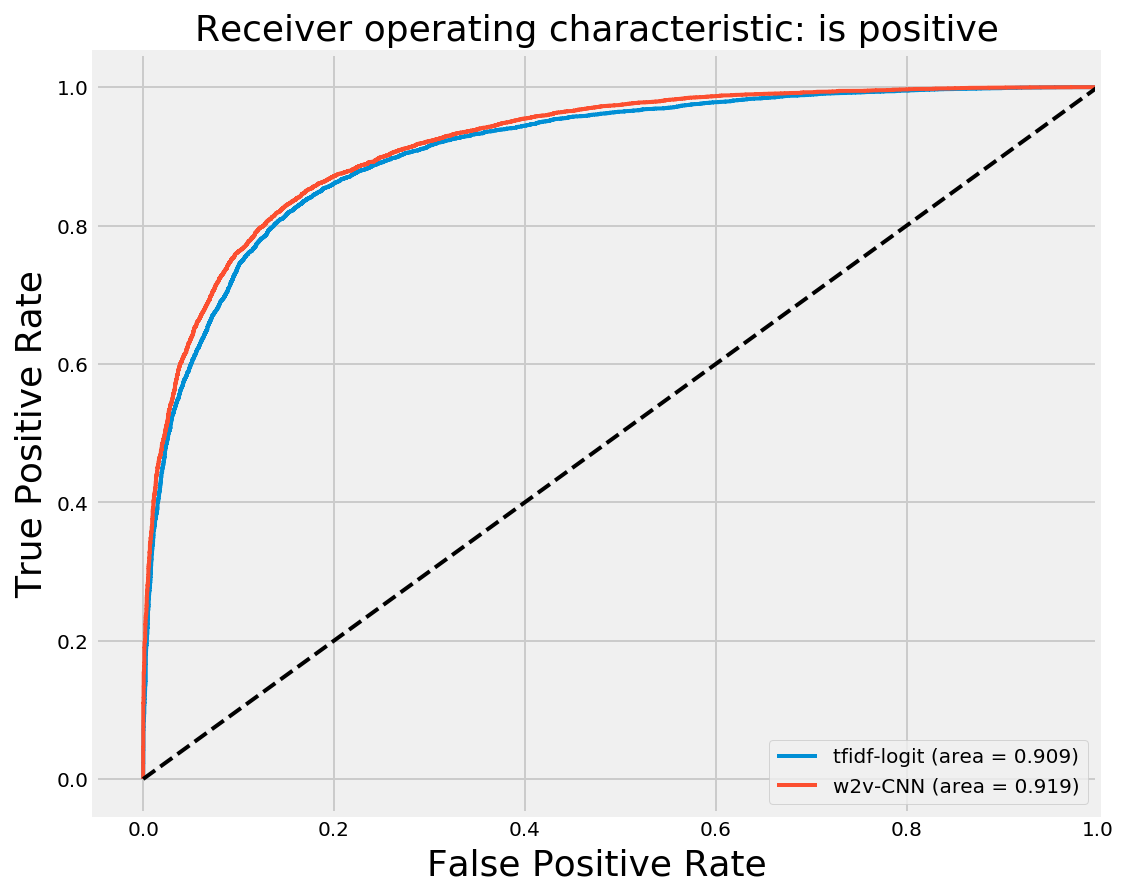

In [139]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

And the final result is as below.

| model | validation set accuracy | test set accuracy | ROC AUC |
|--|--|--|--|--|--|
|Tf-Idf + logistic regression | 82.91% | 83.30% | 0.91 |
|Word2Vec + CNN | 83.33% | 83.86% | 0.92 |